<a href="https://colab.research.google.com/github/sarath-menon/can_final/blob/master/Spectro_avg_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
!pip install git+https://github.com/ARM-software/CMSIS_5.git@5.8.0#egg=CMSISDSP\&subdirectory=CMSIS/DSP/PythonWrapper

%cd
%cd /content/
!git clone https://github.com/sarath-menon/UAV-Propeller-Anomaly-Audio-Dataset.git
%cd UAV-Propeller-Anomaly-Audio-Dataset
!python3 data_prepare.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ARM-software/CMSIS_5.git (to revision 5.8.0) to /tmp/pip-install-ml1o1xel/cmsisdsp_2f876731add84a04be1ee66b97c44cdd
  Running command git clone --filter=blob:none --quiet https://github.com/ARM-software/CMSIS_5.git /tmp/pip-install-ml1o1xel/cmsisdsp_2f876731add84a04be1ee66b97c44cdd
  Running command git checkout -q 649bd8aa41ed7d86b416c89cdb4b820b899a4cbc
  Resolved https://github.com/ARM-software/CMSIS_5.git to commit 649bd8aa41ed7d86b416c89cdb4b820b899a4cbc
  Preparing metadata (setup.py) ... done
  Created wheel for CMSISDSP: filename=CMSISDSP-1.0.0-cp310-cp310-linux_x86_64.whl size=1432088 sha256=e28eca51b8c424f1c5f70640bec78cc49cdb5bb99a737a1f40648b6f718ce10d
  Stored in directory: /tmp/pip-ephem-wheel-cache-mqwcma42/wheels/91/e0/e0/a9f82222f5d1eac8dca08f231ea3bffa47d79f51a2da4355f1
Successfully built CMSISDSP
/root
/content
Cloning into 'UAV-Propeller-An

In [7]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
import seaborn as sns
# Math is Python's math library
import math

import os
import pathlib


from scipy.fft import fft, fftfreq
from tensorflow.keras import datasets, layers, models

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
from tensorflow.keras import layers
from tensorflow.keras import models


## Data preparation

In [8]:
%cd
%cd /content/UAV-Propeller-Anomaly-Audio-Dataset

normal_path = pathlib.Path("NewDataset/normal")
one_broken_path = pathlib.Path("NewDataset/one_broken")
two_broken_path = pathlib.Path("NewDataset/two_broken")

normal_list = list(normal_path.rglob("*.wav"))
one_broken_list = list(one_broken_path.rglob("*.wav"))
two_broken_list = list(two_broken_path.rglob("*.wav"))

/root
/content/UAV-Propeller-Anomaly-Audio-Dataset


In [10]:
from cmsisdsp import arm_float_to_q15, arm_float_to_q7, arm_rfft_instance_q15, arm_rfft_init_q15, arm_rfft_q15
from numpy import pi as PI
from cmsisdsp import arm_cos_f32, arm_float_to_q15
from cmsisdsp import arm_mult_q15
from cmsisdsp import arm_rfft_instance_q15, arm_rfft_init_q15, arm_rfft_q15, arm_cmplx_mag_q15
from scipy.io import wavfile


window_count =  16
window_size = 256
audio_sample_rate = 16000
step_size = int(audio_sample_rate/window_count)

# create the hanning window
hanning_window_f32 = np.zeros(window_size)
for i in range(window_size):
    hanning_window_f32[i] = 0.5 * (1 - arm_cos_f32(2 * PI * i / window_size ))
  
hanning_window_q15 = arm_float_to_q15(hanning_window_f32)

# Calculate the number of windows
number_of_windows = int(1 + (audio_sample_rate - window_size) // step_size)

# Initialize the FFT
rfft_instance_q15 = arm_rfft_instance_q15()
status = arm_rfft_init_q15(rfft_instance_q15, window_size, 0, 1)

# Calculate the FFT Output size
fft_size = int(window_size // 2 )


def convert_to_arm_dsp_spect_efficient(audio_samples):
    # Convert the audio to q15
    audio_samples_q15 = arm_float_to_q15(audio_samples/200)
    
    # Create an empty array to hold the Spectrogram
    spectrogram_q15 = np.empty((number_of_windows,fft_size))
    spectrogram_avg_q15 = np.empty((fft_size))
    
    
    start_index = 0
    # Apply hanning window and apply fft
    for index in range(number_of_windows):
        # Take the window from the waveform.
        audio_window_q15 = audio_samples_q15[start_index:start_index + window_size]

        # Apply the Hanning Window.
        processed_audio_q15 = arm_mult_q15(audio_window_q15, hanning_window_q15)

        # Calculate the FFT
        rfft_q15 = arm_rfft_q15(rfft_instance_q15, processed_audio_q15)

        # Take the absolute value of the FFT and add to the abg
        rfft_mag_q15 = arm_cmplx_mag_q15(rfft_q15)[:fft_size]
        
#         print(np.max(rfft_mag_q15))

        spectrogram_q15[index] =  rfft_mag_q15 / 4

        # Increase the start index of the window by the overlap amount.
        start_index += step_size
    
    
    # average across frequencies
    for i in range(fft_size):
        spectrogram_avg_q15[i] = 0
        
        for j in range(number_of_windows):
            spectrogram_avg_q15[i] = spectrogram_avg_q15[i] + spectrogram_q15[j, i]
    
        
    return spectrogram_avg_q15

In [12]:
def read_wave_file(file):
    # read sample rate and data from wave file
    original_sample_rate, orginal_audio_data = wavfile.read(file)
    
    orginal_audio_data = np.float32(orginal_audio_data)
    audio_data_float32 = orginal_audio_data / np.finfo(orginal_audio_data.dtype).max

    audio_data_float32 = orginal_audio_data
    return audio_data_float32, original_sample_rate


normal_len = len(normal_list)
normal_data = np.empty([normal_len ,128])
normal_labels = [0] *normal_len 

for i, path in enumerate(normal_list):
    audio_samples, audio_sample_rate = read_wave_file(path);
    spectrogram_q15 = convert_to_arm_dsp_spect_efficient(audio_samples);
    normal_data[i,:] = spectrogram_q15;

    
one_broken_len = len(one_broken_list)
one_broken_data = np.empty([one_broken_len,128])
one_broken_labels = [1] * one_broken_len

for i, path in enumerate(one_broken_list):
    audio_samples, audio_sample_rate = read_wave_file(path);
    spectrogram_q15 = convert_to_arm_dsp_spect_efficient(audio_samples);
    one_broken_data[i,:] = spectrogram_q15;

two_broken_len = len(two_broken_list)
two_broken_data = np.empty([two_broken_len,128])
two_broken_labels = [2] * two_broken_len

for i, path in enumerate(two_broken_list):
    audio_samples, audio_sample_rate = read_wave_file(path);
    spectrogram_q15 = convert_to_arm_dsp_spect_efficient(audio_samples);
    two_broken_data[i,:] = spectrogram_q15;
    
data_x = np.concatenate((normal_data,one_broken_data, two_broken_data), axis=0)
data_y = normal_labels + one_broken_labels + two_broken_labels

In [128]:
SHUFFLE_BUFFER_SIZE = 10000

full_dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y))
full_dataset = full_dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=False)

print('Full dataset size:', full_dataset.cardinality().numpy())

DATASET_SIZE = full_dataset.cardinality().numpy()

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print('Train dataset size:', train_dataset.cardinality().numpy())
print('Test dataset size:', test_dataset.cardinality().numpy())
print('Validation dataset size:', val_dataset.cardinality().numpy())

assert (train_dataset.cardinality().numpy()+ test_dataset.cardinality().numpy() + val_dataset.cardinality().numpy()) ==  DATASET_SIZE

Full dataset size: 3094
Train dataset size: 2475
Test dataset size: 309
Validation dataset size: 310


In [129]:
# batch the dataset
BATCH_SIZE = 64

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# add extra dinension for image channel
def add_dimn(spect, labels):
  spect = spect[..., tf.newaxis, tf.newaxis]
  return spect, labels

# train_dataset = train_dataset.map(add_dimn)
# test_ds = test_dataset.map(add_dimn)
# val_ds = val_dataset.map(add_dimn)

train_dataset.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [130]:
input_shape = (4, 28, 1, 1)
x = tf.random.normal(input_shape)
y = layers.Conv2D(2, (3,1), activation='relu', input_shape=input_shape[1:])(x)
print(y.shape)

(4, 26, 1, 2)


In [131]:
for example_spect, example_spect_labels in train_dataset.take(1):  
  print(example_spect.shape)
  print(example_spect_labels.shape)

(64, 128)
(64,)


## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [117]:
DATASET_PATH = '/content/UAV-Propeller-Anomaly-Audio-Dataset/NewDataset'
data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [118]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['normal' 'one_broken' 'two_broken']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [119]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3094 files belonging to 3 classes.
Using 2476 files for training.
Using 618 files for validation.

label names: ['normal' 'one_broken' 'two_broken']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [120]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [121]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [122]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [123]:
def scale_audio(audio, labels):
  audio = audio*25600
  return audio, labels

train_ds = train_ds.map(scale_audio)
test_ds = test_ds.map(scale_audio)
val_ds = val_ds.map(scale_audio)

In [124]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [125]:
label_names[[1,1,2,0]]

array(['one_broken', 'one_broken', 'two_broken', 'normal'], dtype='<U10')

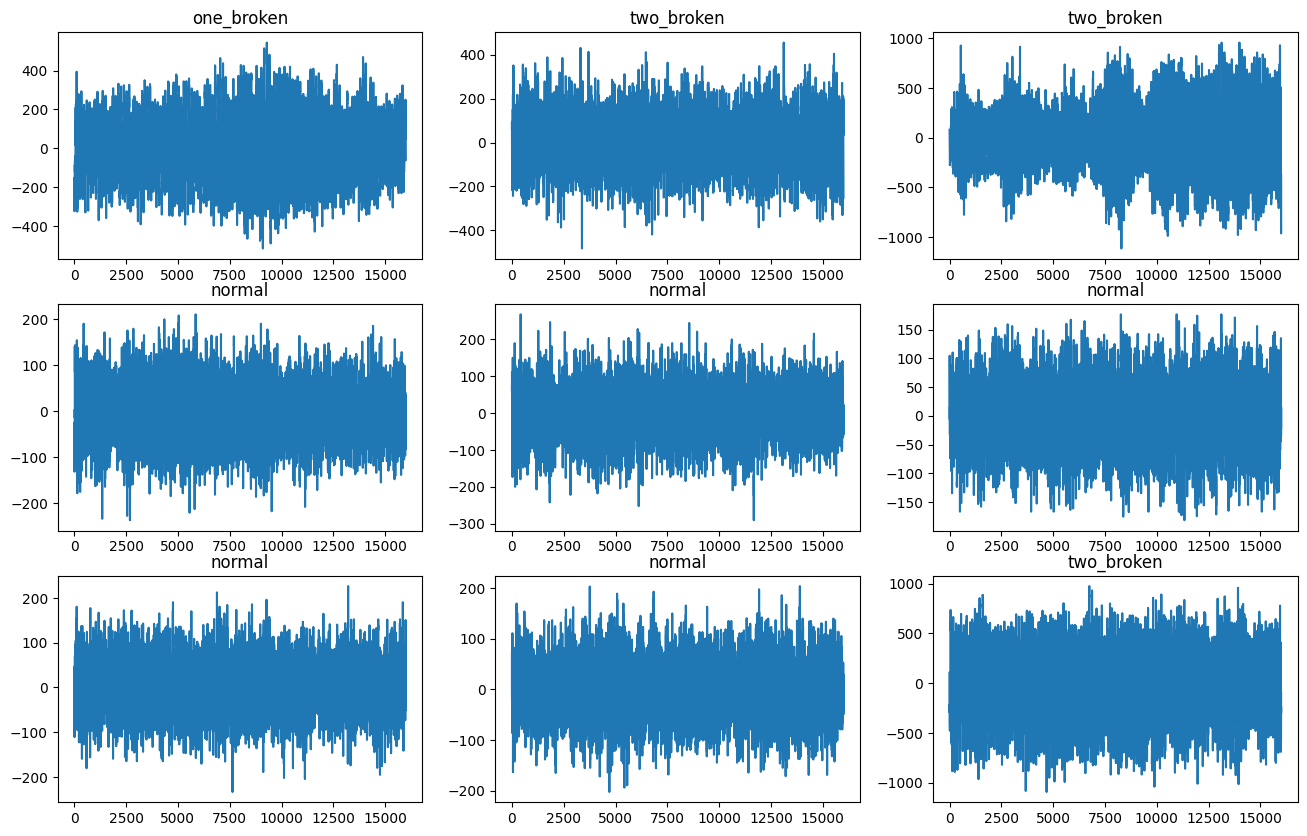

In [126]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  # plt.yticks(np.arange(-1.2, 1.2, 0.2))
  # plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  print(tf.size(spectrogram))
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def get_rfft(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  rfft = tf.signal.rfft(waveform)
  # Obtain the magnitude of the STFT.
  rfft = tf.abs(rfft)
  print(tf.size(rfft))
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  rfft = rfft[..., tf.newaxis]
  return rfft

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)
  rfft = get_rfft(waveform)

Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def plot_rfft(rfft, ax):

  N = np.size(rfft)*2
  T = 1.0 / 16000.0

  X = np.linspace(0.0, N*T, N, endpoint=False)
  xf = fftfreq(N, T)[:N//2]
  yf = 2.0/N * rfft

  ax.plot(xf, yf)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
def plot_spectrogram_arm_dsp(spectrogram, ax, fig= None):
    height = spectrogram.T.shape[0]
    X = np.arange(audio_sample_rate, step=height + 1)
    Y = np.fft.rfftfreq(window_size, d=1./audio_sample_rate)
    im = ax.pcolormesh(X, Y, spectrogram.T, cmap='viridis', shading='auto')

    return im


fig, axes = plt.subplots(2, figsize=(12, 10))

# timescale = np.arange(audio_samples_q15.shape[0])

# axes[0].plot(timescale, audio_samples_q15)
# axes[0].set_title('Waveform')
# axes[0].set_xlim([0, audio_sample_rate])

# Shift for colorbar
fig.subplots_adjust(right=0.85)

# Get axes two coordinates
[[x10,y10],[x11,y11]] = axes[1].get_position().get_points()
pad = 0.01
width = 0.02

im = plot_spectrogram_arm_dsp(example_spect.numpy(), axes[1], fig)

# Add another axes next to colour bar
cbar_ax = fig.add_axes([x11+pad, y10, width, y11-y10])
axcb = fig.colorbar(im, cax=cbar_ax)

_ = axes[1].set_title('Spectrogram')

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_rfft(rfft.numpy(), axes[1])
axes[1].set_title('FFT (Real)')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  
def make_rfft_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_rfft(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

train_rfft_ds = make_rfft_ds(train_ds)
val_rfft_ds = make_rfft_ds(val_ds)
test_rfft_ds = make_rfft_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

print('Size:', example_spectrograms[0].numpy().size)
plt.show()

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_rfft(example_rffts[i].numpy(), ax)
    ax.set_title(label_names[example_rfft_labels[i].numpy()])

print('Size:', example_rffts[0].numpy().size)
plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [16]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_QUANT_TFLITE = MODELS_DIR + 'model_quantized.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [132]:
# train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
# val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
# test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# train_rfft_ds = train_rfft_ds.cache().prefetch(tf.data.AUTOTUNE)
# val_rfft_ds = val_rfft_ds.cache().prefetch(tf.data.AUTOTUNE)
# test_rfft_ds = test_rfft_ds.cache().prefetch(tf.data.AUTOTUNE)

# Pre-processed dataset
train_dataset_ds = train_dataset.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_dataset_ds = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset_ds = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `layers.Resizing`: to downsample the input to enable the model to train faster.
- `layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [133]:
# input_shape = example_spectrograms.shape[1:]
# print('Input shape spectrogram:', input_shape)

input_shape = example_spect.shape[1:]
print('Input shape preprocessed spect:', input_shape)

label_names: ['normal' 'one_broken' 'two_broken']

# input_shape_rfft = example_rffts.shape[1:]
# print('Input shape rfft:', input_shape_rfft)

Input shape preprocessed spect: (128,)


# Pre-processed Spectrogram train

In [105]:
input_shape = example_spect.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)


model = tf.keras.Sequential([
            layers.Conv2D(
                    8, 4,
                    padding="same",
                    activation="relu",
                    input_shape=input_shape),    # output_shape=(batch, 128, 3, 8)
            layers.MaxPool2D((30, 1)),    # (batch, 42, 1, 8)
            layers.Dropout(0.1),    # (batch, 42, 1, 8)
            layers.Conv2D(16, (4, 1), padding="same",
                                                         activation="relu"),    # (batch, 42, 1, 16)
            layers.MaxPool2D((30, 1), padding="same"),    # (batch, 14, 1, 16)
            layers.Dropout(0.1),    # (batch, 14, 1, 16)
            layers.Flatten(),    # (batch, 224)
            layers.Dense(16, activation="relu"),    # (batch, 16)
            layers.Dropout(0.1),    # (batch, 16)
            layers.Dense(num_labels, activation="softmax")    # (batch, 4)
    ])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)   

Input shape: (128, 1, 1)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 128, 1, 8)         136       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 4, 1, 8)          0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 4, 1, 8)           0         
                                                                 
 conv2d_54 (Conv2D)          (None, 4, 1, 16)          528       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 1, 1, 16)         0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)       

In [139]:
input_shape = example_spect.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)


model = tf.keras.Sequential([
            layers.Dense(16, activation="relu", input_shape=input_shape),    # (batch, 16)
            layers.Dense(32, activation="relu"),
            layers.Dense(num_labels, activation="softmax")    # (batch, 4)
    ])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)   

Input shape: (128,)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 16)                2064      
                                                                 
 dense_50 (Dense)            (None, 32)                544       
                                                                 
 dense_51 (Dense)            (None, 3)                 99        
                                                                 
Total params: 2,707
Trainable params: 2,707
Non-trainable params: 0
_________________________________________________________________


In [140]:
EPOCHS = 30


history = model.fit(
    train_dataset_ds,
    validation_data=val_dataset_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


39/39 [==============================] - 1s 6ms/step - loss: 162.7981 - accuracy: 0.6521 - val_loss: 21.1212 - val_accuracy: 0.8645
Epoch 2/30
39/39 [==============================] - 0s 3ms/step - loss: 18.1921 - accuracy: 0.8667 - val_loss: 19.5265 - val_accuracy: 0.8548
Epoch 3/30
39/39 [==============================] - 0s 3ms/step - loss: 14.4275 - accuracy: 0.8808 - val_loss: 12.6416 - val_accuracy: 0.8935
Epoch 4/30
39/39 [==============================] - 0s 3ms/step - loss: 9.5471 - accuracy: 0.8929 - val_loss: 7.9993 - val_accuracy: 0.9161
Epoch 5/30
39/39 [==============================] - 0s 3ms/step - loss: 7.5756 - accuracy: 0.9059 - val_loss: 6.0985 - val_accuracy: 0.9323
Epoch 6/30
39/39 [==============================] - 0s 3ms/step - loss: 6.4491 - accuracy: 0.9184 - val_loss: 6.4029 - val_accuracy: 0.9323
Epoch 7/30
39/39 [==============================] - 0s 3ms/step - loss: 5.9380 - accuracy: 0.9220 - val_loss: 3.6771 - val_accuracy: 0.9419
Epoch 8/30
39/39 [======

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7ff254b12200>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

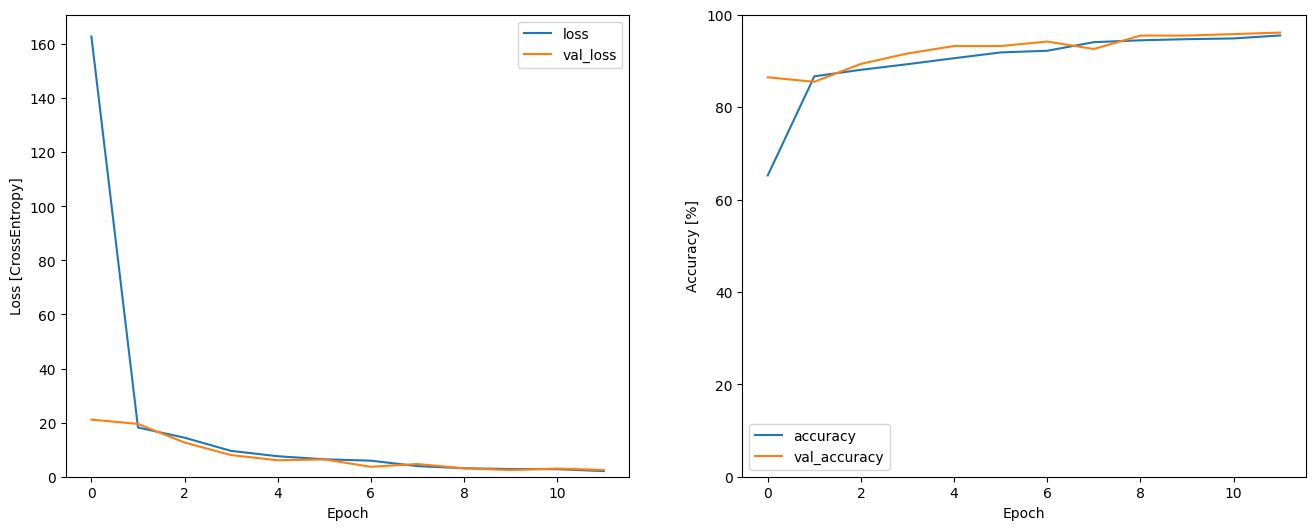

In [142]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [143]:
# model.evaluate(test_spectrogram_ds, return_dict=True)
model.evaluate(test_dataset_ds, return_dict=True)

5/5 [==============================] - 0s 3ms/step - loss: 2.8293 - accuracy: 0.9515


{'loss': 2.829308271408081, 'accuracy': 0.9514563083648682}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


5/5 [==============================] - 0s 3ms/step


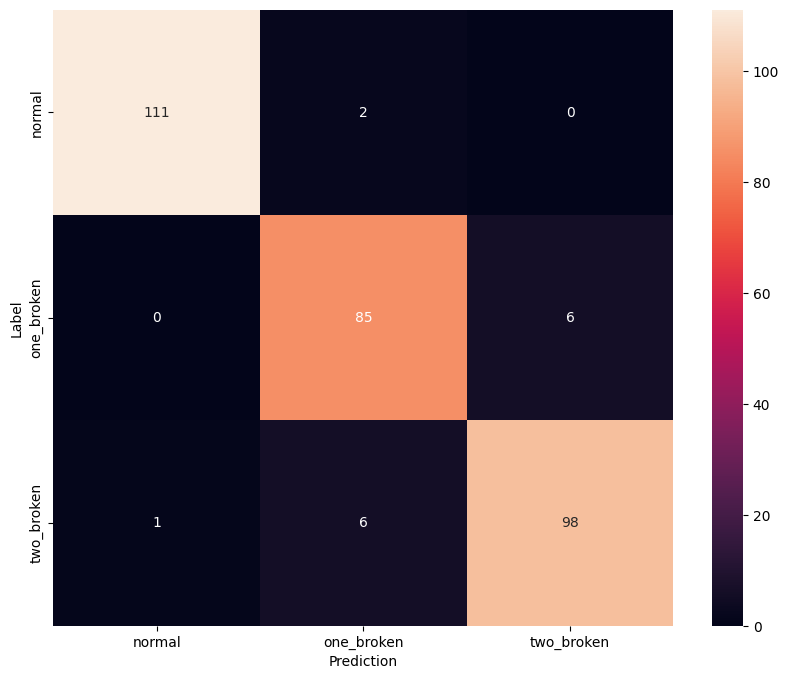

In [144]:


y_pred = model.predict(test_dataset_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_dataset_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
x = data_dir/'two_broken/_0_12_to_14.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['normal', 'one_broke', 'two_broken',]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

tf.Tensor(8001, shape=(), dtype=int32)


ValueError: ignored

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
# class ExportModel(tf.Module):
#   def __init__(self, model):
#     self.model = model

#     # Accept either a string-filename or a batch of waveforms.
#     # YOu could add additional signatures for a single wave, or a ragged-batch. 
#     self.__call__.get_concrete_function(
#         x=tf.TensorSpec(shape=(), dtype=tf.string))
#     self.__call__.get_concrete_function(
#        x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


#   @tf.function
#   def __call__(self, x):
#     # If they pass a string, load the file and decode it. 
#     if x.dtype == tf.string:
#       x = tf.io.read_file(x)
#       x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
#       x = tf.squeeze(x, axis=-1)
#       x = x[tf.newaxis, :]
    
#     x = get_spectrogram(x)  
#     result = self.model(x, training=False)
    
#     class_ids = tf.argmax(result, axis=-1)
#     class_names = tf.gather(label_names, class_ids)
#     return {'predictions':result,
#             'class_ids': class_ids,
#             'class_names': class_names}

Test run the "export" model:

In [ ]:
# export = ExportModel(model)
# export(tf.constant(str(data_dir/'two_broken/_0_12_to_14.wav')))

Save and reload the model, the reloaded model gives identical output:

In [ ]:
# tf.saved_model.save(export, "saved")
# imported = tf.saved_model.load("saved")
# imported(waveform[tf.newaxis, :])

### 1. Generate Models with or without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of a model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, we'll convert the model twice: once with quantization, once without.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()
# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# # Convert the model to the TensorFlow Lite format with quantization
# def representative_dataset():
#   for i in range(500):
#     yield([x_train[i].reshape(1, 1)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # Enforce integer only quantization
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8

# # Provide a representative dataset to ensure we quantize correctly.
# converter.representative_dataset = representative_dataset

model_tflite = converter.convert()
# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

39384

In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,138380 bytes,(reduced by -134284 bytes)
TensorFlow Lite Quantized,39384 bytes,(reduced by 98996 bytes)


## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,776 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,255 kB]
Get:14 http://archiv

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00,
  0x3c, 0x8e, 0x00, 0x00, 0x4c, 0x8e, 0x00, 0x00, 0x30, 0x99, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xb6, 0x70, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff,
  0x11, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x35, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x9a, 0x71, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00,
  0x0e, 0x